In [1]:
using IterativeSolvers, SparseArrays, LinearAlgebra
using ArnoldiMethod
using Interpolations
using LsqFit
using LaTeXStrings
using Plots
using Statistics
using ProgressMeter

id = [1 0; 0 1] |> sparse
sx = [0 1; 1 0] |> sparse
sz = [1 0; 0 -1] |> sparse;

In [2]:
function build_HA(ns, Szi, A=50)
    N = 5*ns + 2
    
    Heff = zeros(N+1, N+1)

    IdN = sparse(1.0I, 2^N, 2^N)

    Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[ns+1])
    Ht = A/4 * (2*IdN + 2*Szi[N]*Szi[4*ns+2])
    
    Heff[2, ns+2] += 2
    Heff[4*ns+3, N+1] += 2
    
    Hij = spzeros(Int, 2^N, 2^N)
    
    # source and tagert horizontal edges
    Hij += IdN - Szi[1]*(Szi[2] + Szi[ns+2]) - 2*Szi[1]
    Hij += IdN - Szi[N]*(Szi[4*ns+1] + Szi[N-1]) - 2*Szi[N]
    
    Heff[2, 3] += -1
    Heff[2, ns+3] += -1
    Heff[1, 2] += -2
    
    Heff[4*ns+2, N+1] += -1
    Heff[N, N+1] += -1
    Heff[1, N+1] += -2
    
    # source and target vertical edges
    Hij += IdN - Szi[ns+1]*(Szi[2*ns+2] + Szi[3*ns+2]) - 2*Szi[ns+1]
    Hij += IdN - Szi[4*ns+2]*(Szi[2*ns+1] + Szi[3*ns+1]) - 2*Szi[4*ns+2]
    
    Heff[ns+2, 2*ns+3] += -1
    Heff[ns+2, 3*ns+3] += -1
    Heff[1, ns+2] += -2
    
    Heff[2*ns+2, 4*ns+3] += -1
    Heff[3*ns+2, 4*ns+3] += -1
    Heff[1, 4*ns+3] += -2
    
    # horizontal corner edges
    Hij += 2*IdN + Szi[ns]*(Szi[2*ns] - Szi[ns-1] - Szi[2*ns+1]) + 2*Szi[ns]
    Hij += 2*IdN + Szi[4*ns+3]*(Szi[3*ns+3] - Szi[4*ns+4] - Szi[3*ns+2]) + 2*Szi[4*ns+3]
    
    Heff[ns+1, 2*ns+1] += 1
    Heff[ns, ns+1] += -1
    Heff[ns+1, 2*ns+2] += -1
    Heff[1, ns+1] += 2
    
    Heff[3*ns+4, 4*ns+4] += 1
    Heff[4*ns+4, 4*ns+5] += -1
    Heff[3*ns+3, 4*ns+4] += -1
    Heff[1, 4*ns+4] += 2
    
    # vertical corner edges
    Hij += 2*IdN + Szi[2*ns+1]*(Szi[3*ns+1] - Szi[ns] - Szi[4*ns+2]) + 2*Szi[2*ns+1]
    Hij += 2*IdN + Szi[3*ns+2]*(Szi[2*ns+2] - Szi[ns+1] - Szi[4*ns+3]) + 2*Szi[3*ns+2]
    
    Heff[2*ns+2, 3*ns+2] += 1
    Heff[ns+1, 2*ns+2] += -1
    Heff[2*ns+2, 4*ns+3] += -1
    Heff[1, 2*ns+2] += 2
    
    Heff[2*ns+3, 3*ns+3] += 1
    Heff[ns+2, 3*ns+3] += -1
    Heff[3*ns+3, 4*ns+4] += -1
    Heff[1, 4*ns+4] += 2

    # middle horizontal external edges
    Hij += 2*IdN + Szi[2*ns+2]*(Szi[3*ns+2] + Szi[ns+2] - Szi[ns+1] - Szi[3*ns+3] - Szi[2*ns+3]) + 2*Szi[2*ns+2]
    Hij += 2*IdN + Szi[3*ns+1]*(Szi[4*ns+1] + Szi[2*ns+1] - Szi[3*ns] - Szi[4*ns+2] - Szi[2*ns]) + 2*Szi[3*ns+1]
    
    Heff[2*ns+3, 3*ns+3] += 1
    Heff[ns+3, 2*ns+3] += 1
    Heff[ns+2, 2*ns+3] += -1
    Heff[2*ns+3, 3*ns+4] += -1
    Heff[2*ns+3, 2*ns+4] += -1
    Heff[1, 2*ns+3] += 2
    
    Heff[3*ns+2, 4*ns+2] += 1
    Heff[2*ns+2, 3*ns+2] += 1
    Heff[3*ns+1, 3*ns+2] += -1
    Heff[3*ns+2, 4*ns+3] += -1
    Heff[2*ns+1, 3*ns+2] += -1
    Heff[1, 3*ns+2] += 2
    
    # lower horizontal internal edges
    for i in 2:ns-1
        Hij += 2*IdN + Szi[i]*(Szi[i+ns] - Szi[i-1] - Szi[i+ns+1] - Szi[i+1])
        
        Heff[i+1, i+1+ns] += 1
        Heff[i, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[i+1, i+2] += -1
    end
    
    # lower vertical internal edges
    for i in ns+2:2*ns
        Hij += 4*IdN + Szi[i]*(Szi[i-ns] + Szi[i+ns] - Szi[i-ns-1] - Szi[i+ns+1] - Szi[i+2*ns+1]) + 2*Szi[i]
                
        Heff[i+1-ns, i+1] += 1
        Heff[i+1, i+1+ns] += 1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[i+1, i+2*ns+2] += -1
        Heff[1, i+1] += 2
    end

    # middle horizontal internal edges
    for i in 2*ns+3:3*ns
        Hij += 2*IdN + Szi[i]*(Szi[i-ns] + Szi[i+ns] - Szi[i-1] - Szi[i-ns-1] - Szi[i+1] - Szi[i+ns+1])
        
        Heff[i+1-ns, i+1] += 1
        Heff[i+1, i+1+ns] += 1
        Heff[i, i+1] += -1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+2] += -1
        Heff[i+1, i+ns+2] += -1
    end
    
    # higher vertical internal edges
    for i in 3*ns+3:4*ns+1
        Hij += 4*IdN + Szi[i]*(Szi[i-ns] + Szi[i+ns] - Szi[i-ns-1] - Szi[i+ns+1] - Szi[i-2*ns-1]) + 2*Szi[i]
        
        Heff[i+1-ns, i+1] += 1
        Heff[i+1, i+1+ns] += 1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[i-2*ns, i+1] += -1
        Heff[1, i+1] += 2
    end
    
    # higher horizontal internal edges
    for i in 4*ns+4:N-1
        Hij += 2*IdN + Szi[i]*(Szi[i-ns] - Szi[i-1] - Szi[i+1] - Szi[i-ns-1])
        
        Heff[i+1-ns, i+1] += 1
        Heff[i, i+1] += -1
        Heff[i+1, i+2] += -1
        Heff[i-ns, i+1] += -1
    end
    
    Heff = A/4 * Heff
    Heff = Heff .+ transpose(Heff)
    
    Hij = A/4 * Hij
    
    HA = Hs + Ht + Hij

    HA, Heff
end


function build_HB(ns, Szi, W, B=1)
    N = 5*ns + 2
    
    IdN = sparse(1.0I, 2^N, 2^N)

    HB = B / 2 * sum(W) * IdN
    for i in 1:N
        HB += B / 2 * W[i] * Szi[i]
    end

    HB
end


function build_Hx(ns)
    N = 5*ns + 2
    
    # vector of operators: [sx, id, ...]
    Sx_list = fill(id, N)
    Sx_list[1] = sx

    HX = spzeros(Int, 2^N, 2^N)
    for i in 1:N
        HX -= foldl(kron, Sx_list)
        Sx_list = circshift(Sx_list, 1)
    end
    HX
end;

In [3]:
function eigs(x; nev=2)
    decomp, history = partialschur(x, nev=nev, which=SR())
    e, v = partialeigen(decomp)
    e, v
end


function compute_dH(v1, v2, Szi)
    
    N = trunc(Int, log2(size(v1, 1)))
    
    v1 = round.(v1)
    v2 = round.(v2)
    
    v1z = zeros(N)
    v2z = zeros(N)
    
    for i in 1:N
        v1z[i] = v1' * Szi[i] * v1
        v2z[i] = v2' * Szi[i] * v2
    end

    sum(abs.(v2z .- v1z)) / 2
end;

In [4]:
ns = 1
N = 5*ns + 2

A = 50

IdN = sparse(1.0I, 2^N, 2^N)

# vector of operators: [sz, id, id, ...]
Sz_list = fill(id, N)
Sz_list[1] = sz

Szi = fill(IdN, N)
for i in 1:N
    Szi[i] = foldl(kron, Sz_list)
    # cyclic shift the operators
    Sz_list = circshift(Sz_list, 1)
end

Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[2])
Ht = A/4 * (2*IdN + 2*Szi[6]*Szi[7])

Hij =  A/4 * (2*IdN - 2*Szi[1]*Szi[3] - 2*Szi[2]*(Szi[4] + Szi[5]) - 2*Szi[2]) # x1 x2
Hij += A/4 * (2*IdN + 2*Szi[3]*Szi[4] - 2*Szi[3]*Szi[6] + 2*Szi[3]) # x3 
Hij += A/4 * (2*IdN + 2*Szi[4]*Szi[5] - 2*Szi[4]*Szi[6] + 4*Szi[4]) # x4 
Hij += A/4 * (2*IdN - 2*Szi[5]*Szi[7] + 2*Szi[5]) # x5
Hij += A/4 * (2*IdN - 2*Szi[6]) # x6 x7
Hij += A/4 * 2*IdN


Heff1 = zeros(N+1, N+1)
Heff1[2, 3] = +2
Heff1[7, 8] = +2

Heff1[2, 4] = -2
Heff1[3, 5] = -2
Heff1[3, 6] = -2
Heff1[1, 3] = -2

Heff1[4, 5] = +2
Heff1[4, 7] = -2
Heff1[1, 4] = +2

Heff1[5, 6] = +2
Heff1[5, 7] = -2
Heff1[1, 5] = +4

Heff1[6, 8] = -2
Heff1[1, 6] = +2

Heff1[1, 7] = -2

Heff1 = Heff1 + transpose(Heff1);
Heff1 = A/4 * Heff1

HA1 = Hs + Ht + Hij;

In [ ]:
Ms = [10000, 10000, 1000, 10000]

ns_max = 3

# critical S
Sc = zeros(ns_max, 2)
# minimum gap
Dmin = zeros(ns_max, 2)

for ns in 1:ns_max
    N = 5*ns + 2

    IdN = sparse(1.0I, 2^N, 2^N)

    # vector of operators: [sz, id, id, ...]
    Sz_list = fill(id, N)
    Sz_list[1] = sz

    Szi = fill(IdN, N)
    for i in 1:N
        Szi[i] = foldl(kron, Sz_list)
        # cyclic shift the operators
        Sz_list = circshift(Sz_list, 1)
    end

    if ns != 1
        HA = build_HA(ns, Szi)
    else
        HA = copy(HA1)
    end

    Hx = build_Hx(ns)

    M = Ms[ns]
    W = rand(N, M)

    # rho = 0.382
    rho = (sqrt(5) - 1) / 2  # 1 / phi
    rho2 = (3 - sqrt(5)) / 2  # 1 / phi^2

    tol = 1e-4

    ScM = zeros(M)
    DminM = zeros(M)
    @showprogress for j in 1:M

        HB = build_HB(ns, Szi, W[:, j])
        Hp = HA + HB

        a = 0
        b = 0.5

        h = b - a
        c = a + rho2 * h
        d = a + rho * h

        H = (1-c)*Hx + c*Hp
        E = eigs(H, nev=2)[1]
        yc = E[2] - E[1]

        H = (1-d)*Hx + d*Hp
        E = eigs(H, nev=2)[1]
        yd = E[2] - E[1]      

        # Required steps to achieve tolerance
        n = trunc(Int, ceil(log(tol / h) / log(rho)))

        for k in 1:n
            if yc < yd  # yc > yd to find the maximum
                b = d
                d = c
                yd = yc
                h = rho * h
                c = a + rho2 * h

                H = (1-c)*Hx + c*Hp
                E = eigs(H, nev=2)[1]
                yc = E[2] - E[1]
            else
                a = c
                c = d
                yc = yd
                h = rho * h
                d = a + rho * h

                H = (1-d)*Hx + d*Hp
                E = eigs(H, nev=2)[1]
                yd = E[2] - E[1]
            end
        end

        if yc < yd
            ScM[j] = (a + d) / 2
        else
            ScM[j] = (b + c) / 2
        end

        H = (1-ScM[j])*Hx + ScM[j]*Hp
        E = eigs(H, nev=2)[1]
        DminM[j] = E[2] - E[1]  
    end
    
    Sc[ns, :] = [mean(ScM), std(ScM) / sqrt(M)]
    Dmin[ns, :] = [mean(DminM), std(DminM) / sqrt(M)]
end

In [5]:
using JLD

# save("2rows.jld", "Sc", Sc, "Dmin", Dmin)

Sc = load("2rows.jld", "Sc")
Dmin = load("2rows.jld", "Dmin")

ns_max = 3;

In [6]:
power_fit(x, p) = p[1] * x.^p[2] .+ p[3]
log_fit(x, p) = p[1] .+ p[2] * log.(x).^p[3]
exp_fit(x, p) = p[1] .+ p[2] * exp.(p[3].*x);

[-28.532037203789336, -4.263524272562877, 0.11950887125401537]
[0.1195922520564678, -2.870668419199609, -8.995095732131656]


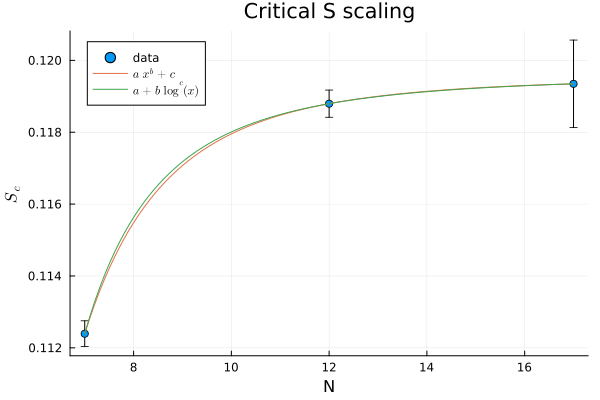

In [7]:
N = [5*ns + 2 for ns in 1:ns_max]

x = LinRange(first(N), last(N), 100)

plt = plot(N, Sc[:, 1], yerr=Sc[:, 2], seriestype=:scatter, label="data")

fit = curve_fit(power_fit, N, Sc[:, 1], Sc[:, 2], [1., -1., 1.])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, N, Sc[:, 1], Sc[:, 2], [1., -1., 1.])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log^c(x)")
println(fit.param)

xlabel!("N")
ylabel!(L"S_{c}")
title!("Critical S scaling")

savefig("2rows_s.pdf")
display(plt)

[2683.358728431704, -4.384126841194132, 7.368111476484904]
[7.362505967963567, 256.36208951739934, -9.271550449805588]


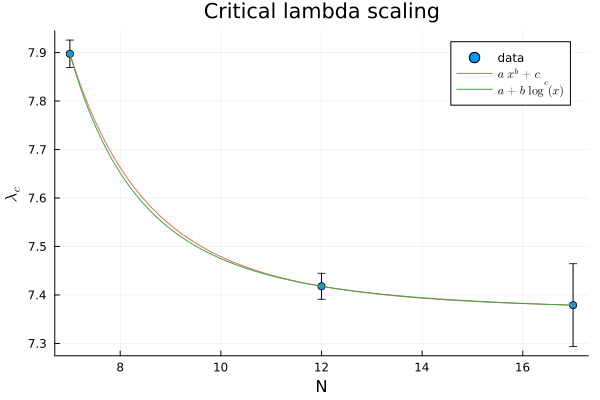

In [8]:
N = [5*ns + 2 for ns in 1:ns_max]

lambda_c = (1 .- Sc[:, 1]) ./ Sc[:, 1]

wt = Sc[:, 1].^2 ./ Sc[:, 2]

x = LinRange(first(N), last(N), 100)

plt = plot(N, lambda_c, yerr=1 ./ wt, seriestype=:scatter, label="data")

fit = curve_fit(power_fit, N, lambda_c, wt, [1., 1., 1.])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, N, lambda_c, wt, [1., 1., 1.])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log^c(x)")
println(fit.param)

xlabel!("N")
ylabel!(L"\lambda_{c}")
title!("Critical lambda scaling")

savefig("2rows_lambda.pdf")
display(plt)

[0.11332024934364053, -0.5276147461434083, -0.003989406027141198]
[3.3446784225358153, -3.2812128831140877, 0.012263957592477923]
[0.016082298937543954, 0.052617891886943075, -0.13453269815111324]


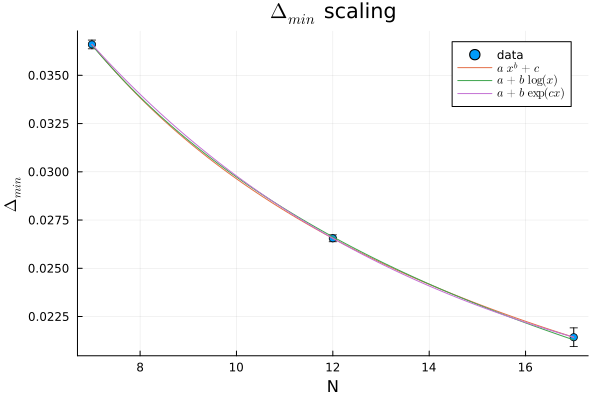

In [9]:
N = [5*ns + 2 for ns in 1:ns_max]
wt = 1 ./ Dmin[:, 2]

x = LinRange(N[1], last(N), 100)

plt = plot(N, Dmin[:, 1], yerr=Dmin[:, 2], seriestype=:scatter, label="data")

fit = curve_fit(power_fit, N, Dmin[:, 1], wt, [0.01, -0.7, 0.005])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, N, Dmin[:, 1], wt, [1., -1., 1.])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log(x)")
println(fit.param)

fit = curve_fit(exp_fit, N, Dmin[:, 1], wt, [.2, .3, -0.5])
plot!(x, exp_fit(x, fit.param), label=L"a + b\ \exp(c x)")
println(fit.param)

xlabel!("N")
ylabel!(L"\Delta_{min}")
title!(L"$\Delta_{min}$ scaling")

savefig("2rows_gap_N.pdf")
display(plt)

[-580.5125011579306, -4.740188709408834, 0.0690286965806771]
[2.380199284587463, -2.6222965616942058, -0.1548495909088477]


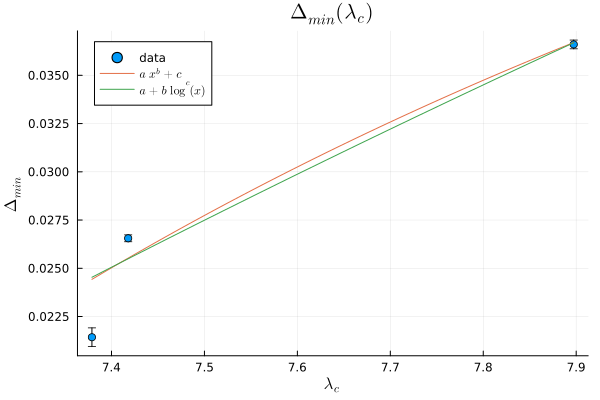

In [10]:
lambda_c = (1 .- Sc[:, 1]) ./ Sc[:, 1]

wt = Sc[:, 1].^2 ./ Sc[:, 2]

x = LinRange(first(lambda_c), last(lambda_c), 100)

plt = plot(lambda_c, Dmin[:, 1], yerr=Dmin[:, 2], seriestype=:scatter, label="data")

fit = curve_fit(power_fit, lambda_c, Dmin[:, 1], wt, [-3., -1., 1.])
plot!(x, power_fit(x, fit.param), label=L" a\ x^b + c")
println(fit.param)

fit = curve_fit(log_fit, lambda_c, Dmin[:, 1], wt, [10., 1., 1.])
plot!(x, log_fit(x, fit.param), label=L"a + b\ \log^c(x)")
println(fit.param)

xlabel!(L"\lambda_{c}")
ylabel!(L"\Delta_{min}")
title!(L"$\Delta_{min}(\lambda_{c})$")

savefig("2rows_gap_lambda.pdf")
display(plt)